In [3]:
import pandas as pd
from fidap import fidap_client
import config

In [4]:
fidap = fidap_client(db="sf_gcp", api_key=config.FIDAP_API_KEY)

In [13]:
def wiki_ticker(ticker: str):
    wiki_query = f"""SELECT R."date", MAX("ticker_value") "ticker", "idlabel_value" "article", R."pageviews", Q."marketcap", Q."close", Q."volume"  FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_companies" L
    LEFT OUTER JOIN
    (SELECT * FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_pages" WHERE "date" > DATEADD(year, -1, CURRENT_DATE())) R ON L."idlabel_value"=R."page" 
    LEFT OUTER JOIN
    (SELECT "close", "volume", "marketcap", "ticker", "date" FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."daily") Q ON L."ticker_value"=Q."ticker" AND R."date"=Q."date" WHERE R."date" IS NOT NULL AND Q."marketcap" IS NOT NULL AND Q."ticker"='{ticker}' GROUP BY "article", R."date", R."pageviews", Q."marketcap", Q."close", Q."volume" ORDER BY R."date" DESC;"""
    
    price_wiki_data = fidap.sql(wiki_query)
    price_wiki_data.set_index('date', inplace=True)
    price_wiki_data.sort_index(ascending=False, inplace=True)
    price_wiki_data[['close', 'pageviews', 'volume']].plot.line(subplots=True, figsize=(10,10), title=ticker)

# Is there a correlation/relationship between ticker price data, volume and wikipedia page views?
## Furthermore, Is there a correlation between "Meme" Stocks and Wikipedia Page Views?
We will list down some common meme stocks from the past year or few months which have been heavily spoken about/traded. Lets look at GME the common one

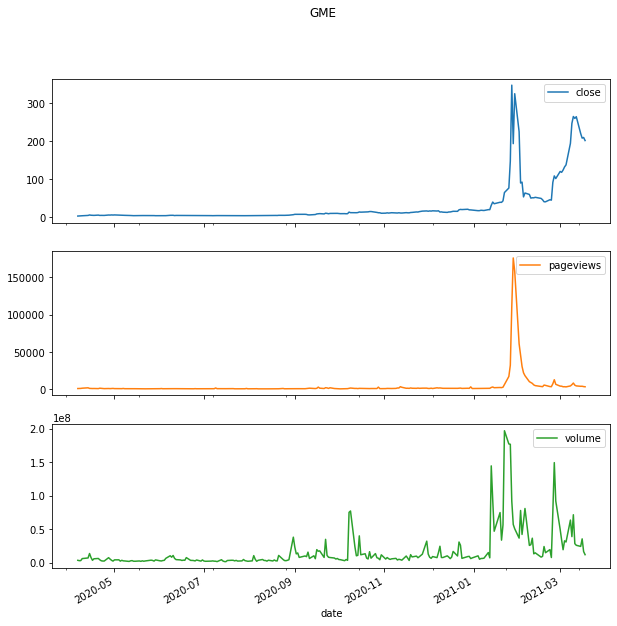

In [14]:
meme_stocks = ["GME"]
for stock in meme_stocks:
    wiki_ticker(stock)

### Look at how the views and price relate with regards to more stable stocks?
In this case we will loook at Microsoft and see how the Price relates to the Wikipedia page number of Views.

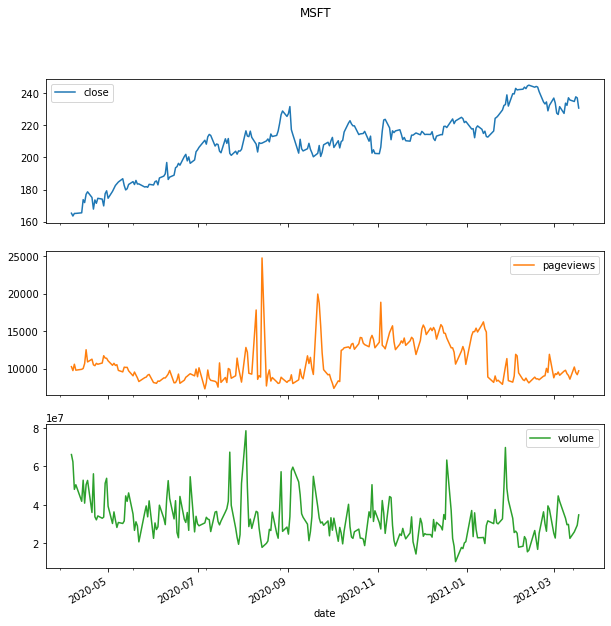

In [15]:
wiki_ticker("MSFT")

# Get the Top 10 Highest Viewed Pages and Check if the Stocks Moved by a large percent on those Days

In [17]:
query=f"""
SELECT R."date", MAX("ticker_value") "ticker", "idlabel_value" "article", R."pageviews", AVG(Q."open") "open", AVG(Q."close") "close", AVG(Q."volume") "volume", AVG(Q."low") "low", AVG(Q."high") "high"  FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_companies" L
LEFT OUTER JOIN
(SELECT * FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."wikidata_pages") R ON L."idlabel_value"=R."page" 
LEFT OUTER JOIN
(SELECT "open","close", "volume", "high", "low", "ticker", "date" FROM "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."daily") Q ON L."ticker_value"=Q."ticker" AND R."date"=Q."date" WHERE R."date" IS NOT NULL GROUP BY "article", R."date", R."pageviews" ORDER BY "pageviews" DESC LIMIT 100;
"""

In [18]:
top_data = fidap.sql(query)

In [20]:
top_data.dropna(inplace=True)

In [21]:
top_data.head()

,date,ticker,article,pageviews,open,close,volume,low,high
0,2019-03-27,GOOGL,Google,773905,1188.71,1175.515,1435821.0,1161.800,1189.740
1,2020-02-04,VOD,Vodacom,491909,19.75,19.640,2927600.0,19.590,19.780
2,2020-11-09,PFE,Pfizer,302622,41.86,39.200,217880635.0,38.380,41.990
3,2019-09-27,GOOGL,Google,298207,1242.92,1225.520,1538456.5,1214.825,1244.505
5,2019-03-28,GOOGL,Google,222127,1173.52,1170.380,1066276.0,1161.430,1174.410


In [24]:
top_data["price_swing_percentage"] = 100 * (top_data["high"] - top_data["low"])/top_data["close"]

In [27]:
top_data.sort_values(ascending=False, by=["price_swing_percentage"], inplace=True)

In [31]:
top_data.head(10)

,date,ticker,article,pageviews,open,close,volume,low,high,price_swing_percentage
11,2021-01-28,GME,GameStop,175970,265.00,193.60,56814826.0,112.250,483.000,191.503099
12,2021-01-29,GME,GameStop,158155,379.71,325.00,50397132.0,250.000,413.980,50.455385
24,2021-01-27,GME,GameStop,110598,354.83,347.51,91688446.0,249.000,380.000,37.696757
45,2020-11-09,BNTX,BioNTech,87684,114.02,104.80,14614871.0,98.510,115.000,15.734733
97,2020-03-19,FFIV,F5 Networks,69591,89.06,98.33,1127792.0,86.510,101.235,14.975084
27,2020-12-10,NET,Cloudflare,104165,77.00,84.05,8564688.0,76.370,86.210,11.707317
19,2020-11-16,MRNA,Moderna,124888,100.31,97.95,70853055.0,93.300,103.200,10.107198
83,2020-03-26,FFIV,F5 Networks,72268,105.18,114.05,1043718.0,104.015,115.350,9.938623
86,2020-04-28,FFIV,F5 Networks,71293,147.85,140.86,4532950.0,140.100,153.560,9.555587
2,2020-11-09,PFE,Pfizer,302622,41.86,39.20,217880635.0,38.380,41.990,9.209184


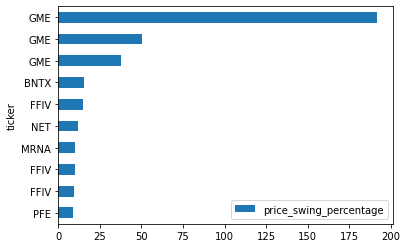

In [30]:
top_data.head(10).plot.barh(x='ticker', y='price_swing_percentage').invert_yaxis()